## Day 44 | 简单 CNN 实战
用一次完整的深度学习流程来体验从 MLP 迈向 CNN：数据增强 → 卷积建模 → 训练调度 → 结果分析。

### 今日目标
> - 回顾 MLP 的局限，明确为何要引入卷积结构
> - 掌握一套可复用的图像数据增强配置
> - 手写一个 3 个卷积块 + 分类头的基础 CNN，并梳理关键超参数
> - 通过可视化观察学习率调度、损失与准确率的演化

### 0. 回顾与动机
MLP 会将 $3\times32\times32=3072$ 个输入映射到 0 个像素完全展平，导致局部空间关系被破坏，只能依赖权重自行“猜测”边缘与纹理信息。卷积层通过局部感受野、权值共享与池化压缩，能够自动提取从低级到高级的多层特征，因此在同等参数量下通常能获得更高的准确率。

如果不清楚什么是卷积神经网络，可以学习参考：https://docs.qq.com/doc/DTFNucmRzc3RlRk5k

### 1. 数据准备与增强
CIFAR-10 官方给出了每个通道的均值 `(0.4914, 0.4822, 0.4465)` 和标准差 `(0.2023, 0.1994, 0.2010)`，直接用于 `Normalize`。训练集添加随机裁剪/翻转/颜色抖动/旋转来模拟真实拍摄噪声，测试集只做张量化 + 标准化以保持分布一致。
> 小技巧：增强操作不会改变 DataLoader 的 batch 数量，而是对样本在线扰动，让每个 epoch 都看到“新”图像。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Matplotlib 的中文显示与负号配置
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

# 检查可用设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# —— 数据增强 ——
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),   # 先填充再裁剪，模拟平移
    transforms.RandomHorizontalFlip(),      # 左右翻转提升鲁棒性
    transforms.ColorJitter(                 # 控制亮度/对比度/饱和度/色调
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomRotation(15),          # 轻微旋转匹配拍摄角度变化
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 测试集仅做确定性处理
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# —— 数据集与加载器 ——
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


使用设备: cuda


### 2. 模型设计路线
1. **卷积块**：`Conv2d → BatchNorm → ReLU → MaxPool` 提取多尺度特征并逐步减小空间维度。
2. **分类头**：将卷积输出展平成向量，接 1~2 层全连接 + Dropout，输出 10 维 logits。
3. **正则化**：BatchNorm 稳定分布、Dropout 降低 co-adaptation。

#### Batch Normalization 的作用
- 以 batch 为单位对每个通道做标准化，缓解“内部协变量偏移”；
- 学习 `gamma` 与 `beta` 进行再缩放，允许网络恢复到任意分布；
- 由于分布稳定，可使用更大学习率，加速收敛并起到轻微正则化效果。

#### 特征图尺寸推导
假设输入尺寸为 \(32\times32\)：
1. 第 1 个卷积块：保持尺寸，池化后得到 `32×16×16`；
2. 第 2 个卷积块：池化后得到 `64×8×8`；
3. 第 3 个卷积块：池化后得到 `128×4×4`，展平即 `2048` 维向量。
这些中间输出就是“特征图”，可借助 Grad-CAM 等方法做可视化解释。

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 第 1 段：输入 3 通道 -> 32 通道，保持空间尺寸，池化对 2
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 32x32 -> 16x16
        )

        # 第 2 段：32 -> 64 通道，继续减半空间尺寸
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 16x16 -> 8x8
        )

        # 第 3 段：64 -> 128 通道，再次减半
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 8x8 -> 4x4
        )

        # 分类头：2048 -> 512 -> 10
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)  # 展平成 (batch, 2048)
        return self.classifier(x)


model = CNN().to(device)


### 3. 损失函数、优化器与学习率调度
- **损失函数**：`CrossEntropyLoss` 直接接收 logits 和标签。
- **优化器**：Adam 适合快速验证，配合适度权重衰减稳定训练。
- **调度器**：`ReduceLROnPlateau` 在验证指标停滞时自动降低学习率，比固定周期衰减更智能。

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=3,
    factor=0.5,
    verbose=True
)


/home/ubuntu24/anaconda3/envs/torch-gpu/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### 4. 训练与可视化流程
训练函数需要做几件事：
1. 记录每个 batch 的损失，以观察局部波动情况；
2. 每个 epoch 统计训练/测试损失与准确率，供调度器和图表使用；
3. 训练结束后绘制迭代级别与 epoch 级别的曲线，帮助定位过拟合或欠拟合。

In [4]:
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, label='Iteration Loss')
    plt.xlabel('Iteration (batch index)')
    plt.ylabel('Loss')
    plt.title('Batch 级别的损失波动')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, test_acc, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('训练 / 测试准确率')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练 / 测试损失')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    model.train()
    iter_losses, iter_indices = [], []
    train_acc_history, test_acc_history = [], []
    train_loss_history, test_loss_history = [], []

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()

            iter_losses.append(loss.item())
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)

            running_loss += loss.item()
            preds = logits.argmax(dim=1)
            total += target.size(0)
            correct += preds.eq(target).sum().item()

            if (batch_idx + 1) % 100 == 0:
                avg_loss = running_loss / (batch_idx + 1)
                print(
                    f"Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f} | AvgLoss: {avg_loss:.4f}"
                )

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100.0 * correct / total
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        model.eval()
        test_loss = 0.0
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data)
                loss = criterion(logits, target)
                test_loss += loss.item()
                preds = logits.argmax(dim=1)
                total_test += target.size(0)
                correct_test += preds.eq(target).sum().item()

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100.0 * correct_test / total_test
        test_loss_history.append(epoch_test_loss)
        test_acc_history.append(epoch_test_acc)

        scheduler.step(epoch_test_loss)
        print(
            f"Epoch {epoch+1}/{epochs} | Train Acc: {epoch_train_acc:.2f}% | Test Acc: {epoch_test_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.5f}"
        )

        model.train()

    plot_iter_losses(iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)
    return test_acc_history[-1]


### 5. 启动训练
默认跑 20 个 epoch 就能看到 70%+ 的测试准确率，如需更高精度，可：
- 增加卷积层深度或使用更大的特征维度；
- 加入 `CosineAnnealingLR`、`Mixup` 等更强的数据/调度策略；
- 使用 `AutoAugment`、`CutMix` 等进阶增强方式。

开始训练 CNN ...
Epoch 1/20 | Batch 100/782 | Loss: 1.9105 | AvgLoss: 2.0645
Epoch 1/20 | Batch 200/782 | Loss: 1.7723 | AvgLoss: 1.9431
Epoch 1/20 | Batch 300/782 | Loss: 1.4931 | AvgLoss: 1.8741
Epoch 1/20 | Batch 400/782 | Loss: 1.6812 | AvgLoss: 1.8228
Epoch 1/20 | Batch 500/782 | Loss: 1.7031 | AvgLoss: 1.7801
Epoch 1/20 | Batch 600/782 | Loss: 1.5635 | AvgLoss: 1.7461
Epoch 1/20 | Batch 700/782 | Loss: 1.5986 | AvgLoss: 1.7165
Epoch 1/20 | Train Acc: 37.31% | Test Acc: 50.18% | LR: 0.00100
Epoch 2/20 | Batch 100/782 | Loss: 1.2607 | AvgLoss: 1.4902
Epoch 2/20 | Batch 200/782 | Loss: 1.3328 | AvgLoss: 1.4745
Epoch 2/20 | Batch 300/782 | Loss: 1.5990 | AvgLoss: 1.4577
Epoch 2/20 | Batch 400/782 | Loss: 1.2616 | AvgLoss: 1.4459
Epoch 2/20 | Batch 500/782 | Loss: 1.3886 | AvgLoss: 1.4380
Epoch 2/20 | Batch 600/782 | Loss: 1.3068 | AvgLoss: 1.4285
Epoch 2/20 | Batch 700/782 | Loss: 1.5703 | AvgLoss: 1.4205
Epoch 2/20 | Train Acc: 48.36% | Test Acc: 57.85% | LR: 0.00100
Epoch 3/20 | Batch 

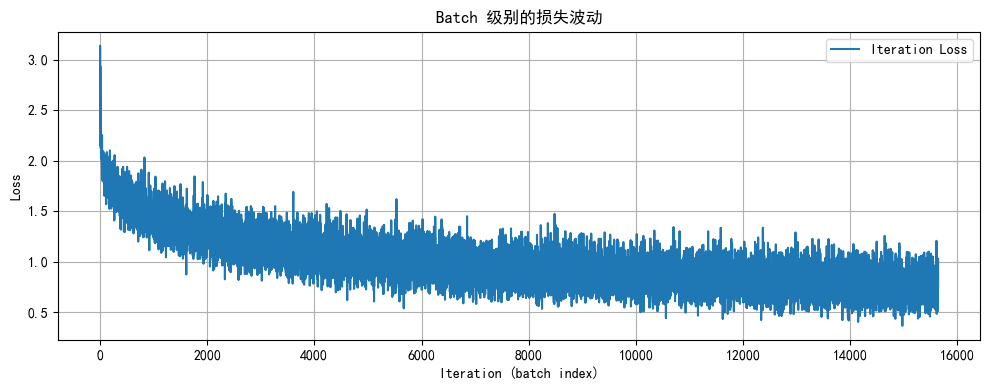

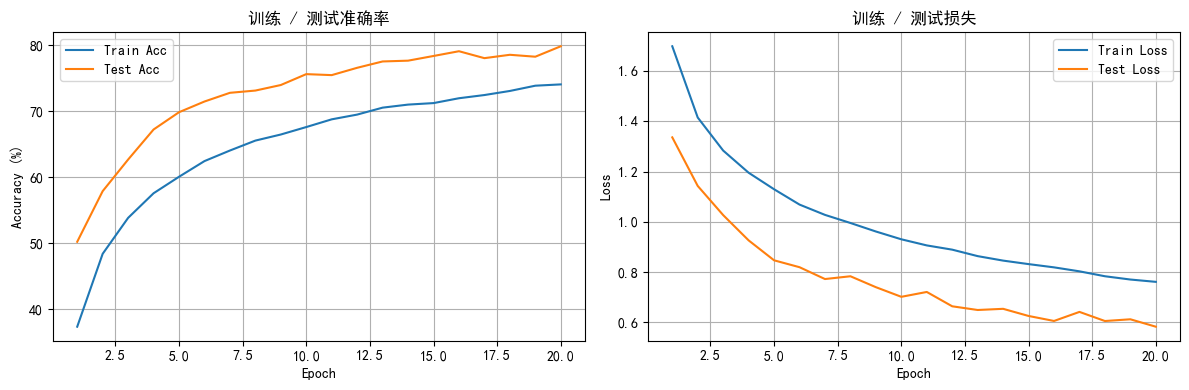

训练结束，最终测试准确率: 79.80%


In [5]:
epochs = 20
print('开始训练 CNN ...')
final_acc = train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs)
print(f'训练结束，最终测试准确率: {final_acc:.2f}%')


### 6. MLP vs CNN 快速对比
| 模型 | 参数规模 (示例) | 特征提取方式 | 计算效率 | 典型准确率 |
| --- | --- | --- | --- | --- |
| MLP (3072→512→256→10) | ≈3.7M | 全连接、打平输入、无空间感知 | 需遍历全部权重，难以复用局部模式 | 50%~55% |
| CNN (3×3 卷积×3 + FC) | ≈0.1M | 局部卷积 + 池化 + 权值共享 | 以卷积核滑动复用计算，GPU 友好 | 70%~80% |

> 不同模型的参数量仅为估算，实际取决于具体层数、通道数和分类头设计。